Adapted from MONAI tutorial:<br>
https://github.com/Project-MONAI/tutorials/blob/master/3d_segmentation/spleen_segmentation_3d.ipynb<br>

Last updated: Jan 12, 2022 by charissa.

In [ ]:
# Install libraries.
!conda install -c conda-forge tqdm -y
!conda install -c conda-forge tensorboard -y
!pip uninstall monai -y
!pip install tensorboard
!pip install 'monai[all]'
!python -c "import matplotlib" || pip install -q matplotlib
!python -c 'import monai; monai.config.print_config()'
%matplotlib inline

In [1]:
from IPython.display import clear_output

In [21]:
import numpy as np
import glob
import os
import tqdm
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import nibabel as nib
import cv2

In [3]:
import torchvision
import torchvision.transforms as transforms
import torch
from torch.nn import BCELoss, BCEWithLogitsLoss, CrossEntropyLoss
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [4]:
import monai
from monai.networks.layers import Norm
from monai.data import create_test_image_2d, list_data_collate, decollate_batch
from monai.visualize import plot_2d_or_3d_image

In [5]:
from monai.utils import first, set_determinism
from monai.transforms import (
    Activations,
    AddChanneld,
    AsDiscrete,
    EnsureChannelFirstd,
    EnsureType,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandAffined,
    RandCropByPosNegLabeld,
    ScaleIntensityd,
    EnsureTyped,
)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric, ConfusionMatrixMetric
from monai.losses import DiceLoss, DiceCELoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config

In [6]:
# Set directories.

root_dir = '/home/charissa/minivess'

images = sorted(glob.glob(os.path.join(root_dir, '20211029_raw_uint8_2d', '*.png')))
labels = sorted(glob.glob(os.path.join(root_dir, '20211029_seg_uint8_2d', '*.png')))

data_dicts = [
    {'image': image_name, 'label': label_name}
    for image_name, label_name in zip(images, labels)
]

# Split data for training and testing.
split = int(len(images)*.8)

train_files = [{"image": img, "label": label} for img, label in zip(images[:split], labels[:split])]
val_files = [{"image": img, "label": label} for img, label in zip(images[split+1:], labels[split+1:])]

In [7]:
daten = input('Input date, which will be used to save relevant plots/images for this run: (yyyymmdd):')
best_model_name = daten +'_best_metric_model.pth'
print(best_model_name)

Input date, which will be used to save relevant plots/images for this run: (yyyymmdd): 20220112


20220112_best_metric_model.pth


In [8]:
# Set random seed.
set_determinism(seed=0)  #42

In [9]:
# Set transforms for training, validation, and saving validation outputs (train_transform2).
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityd(keys=['image', 'label'], minv=0.0, maxv=1.0),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size= (96,96), #(160, 160),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandAffined(
             keys=['image', 'label'],
             mode=('bilinear', 'nearest'),
             prob=1.0, spatial_size=(96, 96),
             rotate_range=(0, 0, np.pi/15),
             scale_range=(0.1, 0.1)),
        EnsureTyped(keys=["image", "label"], data_type='tensor'),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityd(keys=['image', 'label'], minv=0.0, maxv=1.0),
        EnsureTyped(keys=["image", "label"], data_type='tensor'),
    ]
)

train_transforms2 = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityd(keys=['image', 'label'], minv=0.0, maxv=1.0),
        EnsureTyped(keys=["image", "label"], data_type='tensor'),
    ]
)

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)


image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])
label values: [0 1]
image max: 0.5159908533096313, image min: 0.0002281399501953274


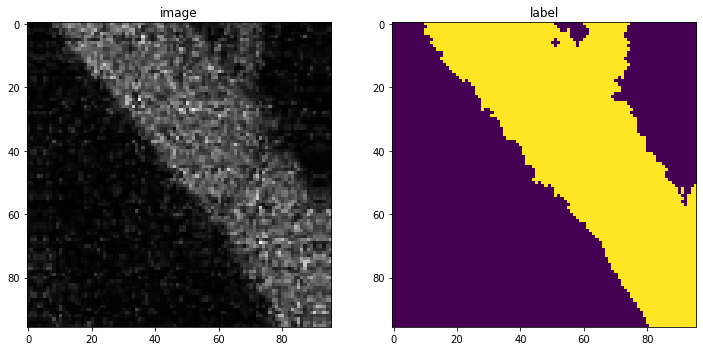

In [10]:
# See example of image, label.
check_ds = Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
label = label.int()
print(f"image shape: {image.shape}, label shape: {label.shape}")
print(f'label values: {np.unique(label)}')
print(f'image max: {image.max()}, image min: {image.min()}')
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :])
plt.show()

In [11]:
# Create Datasets and DataLoaders.

# Dataset and DataLoader for training.
train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(
    train_ds,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=list_data_collate,
    pin_memory=torch.cuda.is_available(),
)

# Dataset and DataLoader for validation.
val_ds = monai.data.Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, collate_fn=list_data_collate)

# Dataset and DataLoader for saving model outputs.
train_ds2 = monai.data.Dataset(data=train_files, transform=train_transforms2)
train_loader2 = DataLoader(train_ds2, batch_size=1, num_workers=4, collate_fn=list_data_collate)

# Metrics
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
confusion_metric = ConfusionMatrixMetric(include_background=True, 
                                        metric_name = ['sensitivity','specificity',
                                                      'precision', 'accuracy'])

post_trans = Compose([EnsureType(data_type='tensor'), Activations(sigmoid=True), AsDiscrete(threshold_values=True)])

`threshold_values=True/False` is deprecated, please use `threshold=value` instead.


In [12]:
# Create UNet, DiceLoss and Adam optimizer.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:', device)

model = monai.networks.nets.UNet(
    dimensions=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

device: cuda:0


In [13]:
# Typical PyTorch training loop.

epochs = 6
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
conf_metric_values = []

for epoch in range(epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        #print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            val_images = None
            val_labels = None
            val_outputs = None
            for val_data in val_loader:
                val_images, val_labels = val_data["image"].to(device), val_data["label"].to(device)
                roi_size = (96, 96)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                # Compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)
                confusion_metric(y_pred=val_outputs, y=val_labels)
            # Aggregate the final mean dice resul
            metric = dice_metric.aggregate().item()
            conf_metric_agg = confusion_metric.aggregate()
            # Reset the status for next validation round
            dice_metric.reset()
            confusion_metric.reset()
            
            metric_values.append(metric)
            conf_metric_values.append(conf_metric_agg)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), best_model_name)
                print("saved new best metric model")
            print(
                "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                    epoch + 1, metric, best_metric, best_metric_epoch
                )
            )
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")


----------
epoch 1/6


N foreground 0, N  background 261171,unable to generate class balanced samples.


epoch 1 average loss: 0.6001
----------
epoch 2/6


N foreground 0, N  background 261171,unable to generate class balanced samples.


epoch 2 average loss: 0.3211


the ground truth of class 0 is all 0, this may result in nan/inf distance.


saved new best metric model
current epoch: 2 current mean dice: 0.7516 best mean dice: 0.7516 at epoch 2
----------
epoch 3/6


N foreground 0, N  background 261171,unable to generate class balanced samples.


epoch 3 average loss: 0.2992
----------
epoch 4/6


N foreground 0, N  background 261171,unable to generate class balanced samples.


epoch 4 average loss: 0.2928
saved new best metric model
current epoch: 4 current mean dice: 0.7729 best mean dice: 0.7729 at epoch 4
----------
epoch 5/6


N foreground 0, N  background 261171,unable to generate class balanced samples.


epoch 5 average loss: 0.2958
----------
epoch 6/6


N foreground 0, N  background 261171,unable to generate class balanced samples.


epoch 6 average loss: 0.2914
current epoch: 6 current mean dice: 0.7130 best mean dice: 0.7729 at epoch 4
train completed, best_metric: 0.7729 at epoch: 4


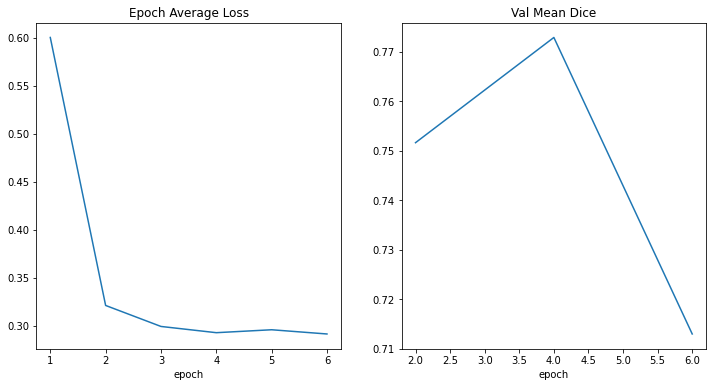

In [14]:
# Plot loss and mean Dice.

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.savefig(daten + best_model_name[:-4] + '_diceloss.jpg')
plt.show()

In [17]:
# Write epoch loss values and dice values to file.

export_prefix = daten + '_unet'
export_diceloss = export_prefix + '_diceloss.txt'
export_dicemetric = export_prefix + '_dicemetric.txt'
export_confusionmetric = export_prefix + '_confusionmetric.txt'

with open(export_diceloss, 'a') as myfile1:
    myfile1.write('\n'.join(str(item) for item in epoch_loss_values)+'\n')
with open(export_dicemetric, 'a') as myfile2:
    myfile2.write('\n'.join(str(item) for item in metric_values)+'\n')
with open(export_confusionmetric, 'a') as myfile3:
    myfile3.write('\n'.join(str(item) for item in conf_metric_values)+'\n')

In [ ]:
# Visualize model outputs on validation set.
post_trans = Compose([EnsureType(data_type='tensor'), Activations(sigmoid=True), AsDiscrete(threshold_values=True)]) 
model.load_state_dict(torch.load(
    os.path.join(root_dir, best_model_name)))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        fname = '20211102-2d_dict-TEST' + str(i) + '.jpg'
        roi_size = (160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        val_outputs = post_trans(val_outputs)
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :], cmap="gray")
        #print('val_data-image:' ,np.unique(val_data["image"][0, 0, :, :]))
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :], cmap='gray')
        print('val_data-label:' ,np.unique(val_data["label"][0, 0, :, :]))
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(val_outputs.detach().cpu()[0, 0,:, :], cmap='gray')
        print('val_outputs shape:', val_outputs.shape, val_outputs.dtype)
        print('val_outputs:', np.unique(val_outputs.detach().cpu()))
        plt.show()

In [ ]:
# For saving model outputs: export headers of train_files into list for .nii.gz
train_header_dict = {}
import nibabel as nib
for i in range(0, len(train_files)):
    key = os.path.split(train_files[i]['label'])[1]  # get file name
    nii_im = nib.load(train_files[i]['label'])
    value = nii_im.header
    train_header_dict[key] = value

In [ ]:
# For saving model outputs:  export headers of val_files into list for .nii.gz
val_header_dict = {}
import nibabel as nib
for i in range(0, len(val_files)):
    key = os.path.split(val_files[i]['label'])[1]  # get file name
    nii_im = nib.load(val_files[i]['label'])
    value = nii_im.header
    val_header_dict[key] = value

[  0 255]
uint8


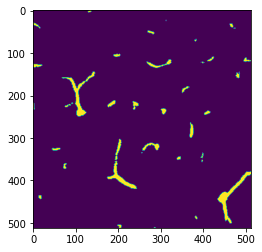

In [19]:
post_trans = Compose([EnsureType(data_type='tensor'), AsDiscrete(threshold_values=True)]) 
val_outputs = post_trans(val_outputs)
val_outputs2 = np.asarray(val_outputs.detach().cpu())
val_outputs2 = np.squeeze(val_outputs2).astype('uint8')
val_outputs2 *= 255
#plt.imshow(val_outputs2.detach().cpu()[0,0,:,:])
plt.imshow(val_outputs2)
print(np.unique(val_outputs2))
print(val_outputs2.dtype)

In [ ]:
# For saving model outputs: save model outputs (val)
#model.load_state_dict(torch.load("/home/charissa/minnievess/runs/20210819_unet_int/best_metric_model_int.pth"))
export_root = root_dir + '/' + best_model_name[:-4] + '_val_outputs/'
if not os.path.isdir(export_root):
    os.mkdir(export_root)
post_trans = Compose([EnsureType(data_type='tensor'), AsDiscrete(threshold_values=True)]) 
model.load_state_dict(torch.load(
    os.path.join(root_dir, best_model_name)))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        val_outputs = post_trans(val_outputs)
        val_outputs2 = np.asarray(val_outputs.detach().cpu())
        val_outputs2 = np.squeeze(val_outputs2).astype('uint8')
                
        val_outputs2 *= 255
        
        # Set file name for png
        f1 = val_data['image_meta_dict']['filename_or_obj']
        _, outputs_fname = os.path.split(f1[0])
        fout = os.path.join(export_root, outputs_fname)
        #print(fout)
        
        
        
        cv2.imwrite(fout, val_outputs2)
        #plt.imshow(val_outputs2, cmap='gray')
        #plt.show()

In [ ]:
# For saving model outputs: save model outputs (train)
#model.load_state_dict(torch.load("/home/charissa/minnievess/runs/20210819_unet_int/best_metric_model_int.pth"))
export_root = root_dir + '/' + best_model_name[:-4] + '_train_outputs/'
if not os.path.isdir(export_root):
    os.mkdir(export_root)
post_trans = Compose([EnsureType(data_type='tensor'), AsDiscrete(threshold_values=True)]) 
model.load_state_dict(torch.load(
     os.path.join(root_dir, best_model_name)))
model.eval()

with torch.no_grad():
    for i, train_data in enumerate(train_loader2):
        roi_size = (160, 160)
        sw_batch_size = 4
        train_outputs = sliding_window_inference(
            train_data["image"].to(device), roi_size, sw_batch_size, model
        )
        train_outputs = post_trans(train_outputs)
        train_outputs2 = np.asarray(train_outputs.detach().cpu())
        train_outputs2 = np.squeeze(train_outputs2).astype('uint8')
      
        train_outputs2 *= 255  # for saving purposes
   
        # set file name for png
        f1 = train_data['image_meta_dict']['filename_or_obj']
        _, outputs_fname = os.path.split(f1[0])
        fout = os.path.join(export_root, outputs_fname)
        
        cv2.imwrite(fout, train_outputs2)